In [1]:
import os
import itertools

import pandas
import matplotlib
import seaborn
import lifelines

from lifelines.statistics import logrank_test

In [2]:
FIG_SIZE = (6, 2.5)
FIG_SIZE_WIDE = (14, 2.5)
FIGURE_PATH = '../figures'

ECOSYSTEMS = ['Cargo', 'NPM', 'Packagist', 'Rubygems']
DATE_RANGE = pandas.to_datetime('2013-01-01'), pandas.to_datetime('2018-01-01')
CENSOR_DATE = pandas.to_datetime('2018-03-15')
P_VALUE = 0.05  # Not corrected

PALETTE = seaborn.color_palette(n_colors=len(ECOSYSTEMS))
SEC_PALETTE = seaborn.color_palette('muted')

COLORS = {e: PALETTE[i] for i, e in enumerate(ECOSYSTEMS)}

In [3]:
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = FIG_SIZE
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

def _savefig(fig, name):
    fig.savefig(
        os.path.join(FIGURE_PATH, '{}.pdf'.format(name)),
        bbox_inches='tight'
    )

# Disable figure export
SAVEFIG = True
savefig = _savefig if SAVEFIG else lambda x, y: None

# Load and transform data

In [4]:
df_versions = dict()
for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    df_versions[ecosystem] = (
        pandas.read_csv(
            '../data/{}-versions.csv.gz'.format(ecosystem),
        )
        .assign(
            date=lambda d: pandas.to_datetime(d['date'], infer_datetime_format=True),
        )
    )
    
    print('.. identify next release')
    df_versions[ecosystem] = (
        df_versions[ecosystem]
        .merge(
            (
                df_versions[ecosystem]
                .assign(rank=lambda d: d['rank'] - 1)
                .rename(columns={'date': 'next_date'})
                [['package', 'rank', 'next_date']]
            ),
            how='left',
            on=['package', 'rank']
        )
    )
    
print('Done!')

Loading Cargo
.. identify next release
Loading NPM
.. identify next release
Loading Packagist
.. identify next release
Loading Rubygems
.. identify next release
Done!


In [5]:
mask_semver = {
    'Semver': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_patch']),
    'Cargo': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_minor'] & d['allows_patch']),
    'NPM': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_minor'] & d['allows_patch']),
    'Packagist': lambda d: (~d['allows_major'] & d['allows_minor'] & ~d['dev']) | (d['dev'] & ~d['allows_minor'] & d['allows_patch']),
    'Rubygems': lambda d: (~d['allows_major'] & d['allows_minor']),
}
 
mask_permissive = {
    'Semver': lambda d: d['allows_major'] | (d['dev'] & d['allows_patch']),
    'Cargo': lambda d: d['allows_major'] | (d['dev'] & d['allows_minor']),
    'NPM': lambda d: d['allows_major'] | (d['dev'] & d['allows_minor']),
    'Packagist': lambda d: d['allows_major'] | (d['dev'] & d['allows_minor']),
    'Rubygems': lambda d: d['allows_major'],
}

mask_restrictive = {
    'Semver': lambda d: ~d['allows_minor'] & ~d['dev'],
    'Cargo': lambda d: ~d['allows_patch'] | (~d['dev'] & ~d['allows_minor']),
    'NPM': lambda d: ~d['allows_patch'] | (~d['dev'] & ~d['allows_minor']),
    'Packagist': lambda d: ~d['allows_patch'] | (~d['dev'] & ~d['allows_minor']),
    'Rubygems': lambda d: ~d['allows_minor'],
}

In [6]:
df_dependencies = dict()
for ecosystem in ECOSYSTEMS:
    print('Loading', ecosystem)
    df_dependencies[ecosystem] = (
        pandas.read_csv(
            '../data/{}-dependencies.csv.gz'.format(ecosystem),
        )
        .merge(
            df_versions[ecosystem][['package', 'version', 'rank', 'date', 'next_date']],
            how='left',
            on=['package', 'version']
        )
       .assign(**{
            'compliant': mask_semver['Semver'],
            'permissive': mask_permissive['Semver'],
            'restrictive': mask_restrictive['Semver'],
        })
        #.assign(**{
        #    'semver_compliant': mask_semver['Semver'],
        #    'semver_permissive': mask_permissive['Semver'],
        #    'semver_restrictive': mask_restrictive['Semver'],
        #})
    )    
    
print('Done!')

Loading Cargo
Loading NPM
Loading Packagist
Loading Rubygems
Done!


In [7]:
df_constraints = dict()

for ecosystem in ECOSYSTEMS:
    print('Considering', ecosystem)
    
    df_tmp = df_dependencies[ecosystem].sort_values('rank')
    
    df_constraints[ecosystem] = (
        df_tmp
        .drop_duplicates(['package', 'target', 'constraint'], keep='first')
        .merge(
            (
                df_tmp
                .drop_duplicates(['package', 'target', 'constraint'], keep='last')
                [['package', 'target', 'constraint', 'rank', 'next_date']]
                .assign(next_rank=lambda d: (d['rank'] + 1).where(~d['next_date'].isnull()))
                .rename(columns={'next_date': 'constraint_next_date', 'next_rank': 'constraint_next_rank'})
                [['package', 'target', 'constraint', 'constraint_next_date', 'constraint_next_rank']]
            ),
            how='left',
            on=['package', 'target', 'constraint']
        )
        .merge(
            (
                df_tmp
                .drop_duplicates(['package', 'target'], keep='first')
                .assign(constraint_is_new=True)
                [['package', 'target', 'rank', 'constraint_is_new']]
            ),
            how='left',
            on=['package', 'target', 'rank']
        )
        .fillna({'constraint_is_new': False})
    )
print('Done!')

Considering Cargo
Considering NPM
Considering Packagist
Considering Rubygems
Done!


# Overview

## Number of packages, releases and dependencies

[None,
 Text(0,0.5,'packages and releases'),
 (734869.0, 736695.0),
 Text(0.5,0,'')]

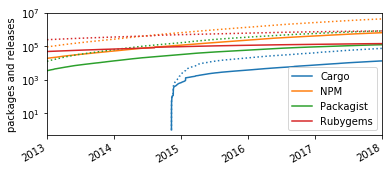

In [8]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()

for ecosystem in ECOSYSTEMS:
    df_tmp = (
        df_versions[ecosystem]
        .set_index('date')
        .sort_index()
    )
    
    data[ecosystem] = (
        df_tmp
        .drop_duplicates(['package'], keep='first')
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
        ,
        df_tmp
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()        
    )
    
    data[ecosystem][0].plot(ax=ax, color=COLORS[ecosystem])
    data[ecosystem][1].plot(ax=ax, legend=False, style=':', color=COLORS[ecosystem])
    
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='packages and releases',
    yscale='log', 
)

#savefig(fig, 'overview_number_packages_releases')

In [9]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem, data[ecosystem][0].max().values, data[ecosystem][1].max().values)

Cargo [14491] [80778]
NPM [676277] [4382693]
Packagist [126363] [832899]
Rubygems [143737] [825386]


[None,
 Text(0,0.5,'cumulative number of dependencies'),
 (734869.0, 736695.0),
 Text(0.5,0,'')]

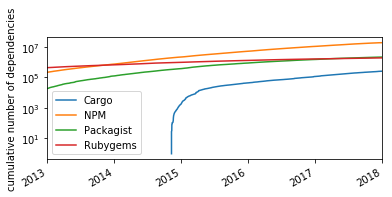

In [10]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .set_index('date')
        .sort_index()
        .assign(**{ecosystem: 1})
        [[ecosystem]]
        .cumsum()
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='cumulative number of dependencies',
    yscale='log', 
)

#savefig(fig, 'overview_number_dependencies')

In [11]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem, data[ecosystem].max().values)

Cargo [292470]
NPM [19669409]
Packagist [2273465]
Rubygems [1970396]


## Monthly proportion of parsed dependencies

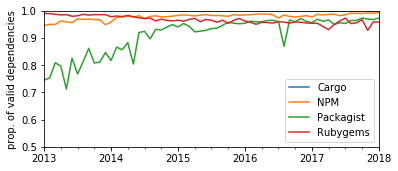

In [12]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .assign(version=1)        
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['empty', 'version']]
        .sum()
        .assign(**{ecosystem: lambda d: (d['version'] - d['empty']) / d['version']})
        [[ecosystem]]
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of valid dependencies',
    ylim=(0.5, 1.00),
)

savefig(fig, 'overview_proportion_valid_dependencies')

In [13]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.999993,0.978316,0.909829,0.966960
std,0.000031,0.011300,0.069609,0.013949
min,0.999837,0.946450,0.712144,0.928383
25%,1.000000,0.975176,0.865587,0.958182
50%,1.000000,0.981921,0.942185,0.965634
75%,1.000000,0.985683,0.960370,0.978888
max,1.000000,0.992288,0.973335,0.990661


In [14]:
(
    df_dependencies['Packagist']
    .assign(before2015=lambda d: d['date'] <= pandas.to_datetime('2015-01-01'))
    .groupby(['before2015', 'empty'])
    [['version']]
    .count()
)

version
before2015 empty         
False      False  1808952
           True     85846
True       False   328531
           True     50136

# Dependency constraint usage

## Monthly proportion of pre-1.0.0 constraints

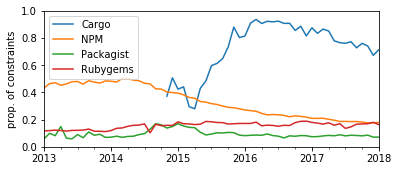

In [15]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .assign(zero=lambda d: d['dev'].astype(int))
        .assign(constraint=1)
        .groupby(pandas.Grouper(key='date', freq='1M'))
        [['constraint', 'zero']]
        .sum()
        .assign(**{ecosystem: lambda d: d['zero'] / d['constraint']})
        [[ecosystem]]
    )
    data[ecosystem].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of constraints',
    ylim=(0, 1),
)

savefig(fig, 'dev_proportion_constraints')

In [16]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.727462,0.337873,0.094602,0.154944
std,0.192815,0.116117,0.027945,0.023695
min,0.279651,0.176047,0.058276,0.102568
25%,0.622591,0.226868,0.078071,0.135807
50%,0.776425,0.323098,0.084806,0.159490
75%,0.879634,0.463607,0.102035,0.171580
max,0.937238,0.502245,0.170219,0.188563


In [17]:
for ecosystem in ECOSYSTEMS: 
    print(ecosystem, data[ecosystem].reset_index()[lambda d: d['date'].between(*DATE_RANGE)].iloc[-1][ecosystem])

Cargo 0.6732227965362153
NPM 0.176345993561559
Packagist 0.0712610100473598
Rubygems 0.1801084460944751


## Monthly proportion of required packages with a pre-1.0.0 reverse dependency constraint

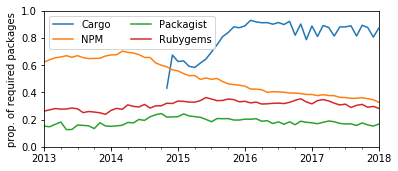

In [18]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()
for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .groupby(['target', pandas.Grouper(key='date', freq='1M')])
        .agg({'dev': 'max'})
        .reset_index('target', drop=True)
        .reset_index()
        .assign(required=1)
        .groupby(pandas.Grouper(key='date', freq='1M'))
        .sum()
        [lambda d: d['required'] > 0]
        .assign(**{ecosystem: lambda d: d['dev'] / d['required']})
    )
    data[ecosystem][[ecosystem]].plot(ax=ax, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of required packages',
    ylim=(0, 1),
)

ax.legend(ncol=2, loc='upper left')
savefig(fig, 'dev_proportion_required')

In [19]:
pandas.concat([
    data[ecosystem][[ecosystem]]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.808401,0.516000,0.183493,0.309315
std,0.123758,0.123584,0.027677,0.029918
min,0.431818,0.346077,0.126332,0.238658
25%,0.760043,0.396156,0.162453,0.285508
50%,0.877137,0.499807,0.181205,0.315337
75%,0.893720,0.652541,0.203033,0.331748
max,0.930841,0.703922,0.244657,0.362282


In [20]:
for ecosystem in ECOSYSTEMS: 
    print(ecosystem, data[ecosystem].reset_index()[lambda d: d['date'].between(*DATE_RANGE)].iloc[-1][ecosystem])

Cargo 0.8076659822039699
NPM 0.3460771276595745
Packagist 0.1522258414766558
Rubygems 0.297221103503826


## Monthly proportion of post-1.0.0 constraints w.r.t. semver

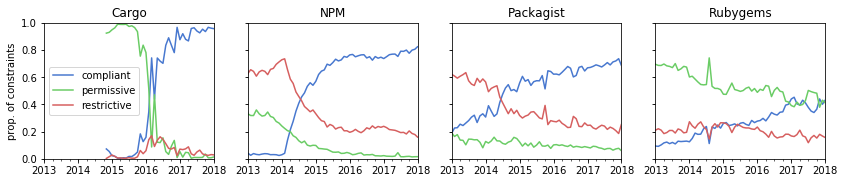

In [21]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=len(ECOSYSTEMS), sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: ~d['dev']]
        .assign(n=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [['compliant', 'permissive', 'restrictive', 'n']]
        .sum()
        [lambda d: d['n'] > 0]
        .apply(lambda d: d / d['n'], axis=1)
        [['compliant', 'permissive', 'restrictive']]
    )
    
    data[ecosystem].plot(ax=ax, legend=False, color=SEC_PALETTE)
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='prop. of constraints',
        ylim=(0, 1),
    )
    
axes[0].legend(title=None, loc='center left')
savefig(fig, 'usage_compliance_post1')

In [22]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .iloc[-1]
for ecosystem in ECOSYSTEMS], axis=1)

,37,85,76,159
date,2017-12-31 00:00:00,2017-12-31 00:00:00,2017-12-31 00:00:00,2017-12-31 00:00:00
compliant,0.96138,0.806116,0.736668,0.401335
permissive,0.00760066,0.015353,0.0773245,0.431363
restrictive,0.0310189,0.178531,0.186008,0.167302
ecosystem,Cargo,NPM,Packagist,Rubygems


What happens for Cargo in early 2016? It seems to be related with the prohibited use of "*" constraints.

[(0, 1), Text(0,0.5,'prop. of wildcards'), (516, 576)]

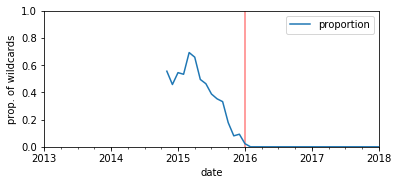

In [23]:
data_temp = (
    df_dependencies['Cargo']
    .assign(wildcard=lambda d: d['constraint'] == '*')
    .groupby(pandas.Grouper(key='date', freq='M'))
    .agg({'package': 'count', 'wildcard': 'sum'})
    .assign(proportion=lambda d: d['wildcard'] / d['package'])
)

ax = data_temp[['proportion']].plot()

ax.vlines(pandas.to_datetime('2016-01-22'), 0, 1, colors='r', alpha=0.5)

ax.set(
    xlim=DATE_RANGE,
    ylim=(0, 1), 
    ylabel='prop. of wildcards',
)

In [24]:
for date in ['2015-01-31', '2015-12-31', '2016-01-31', '2016-02-29', '2016-03-31']:
    print(date, data_temp.loc[pandas.to_datetime(date)]['proportion'])

2015-01-31 0.5456936226166995
2015-12-31 0.09259259259259259
2016-01-31 0.022795302786092562
2016-02-29 0.0
2016-03-31 0.0


## Monthly proportion of pre-1.0.0 constraints w.r.t. semver

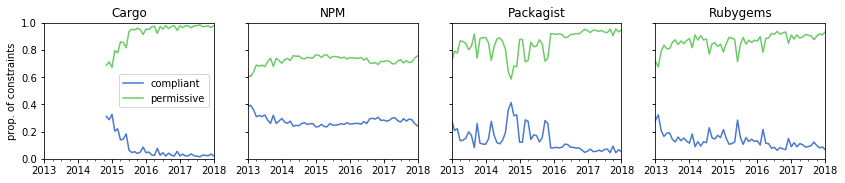

In [45]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=len(ECOSYSTEMS), sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: d['dev']]
        .assign(n=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [['compliant', 'permissive', 'restrictive', 'n',
         'allows_major', 'allows_minor', 'allows_patch']]
        .sum()
        [lambda d: d['n'] > 0]
        .apply(lambda d: d / d['n'], axis=1)
    )
    
    data[ecosystem][['compliant', 'permissive']].plot(ax=ax, legend=False, color=SEC_PALETTE)

    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='prop. of constraints',
        ylim=(0, 1),
    )
    
axes[0].legend(title=None, loc='center right')
savefig(fig, 'usage_compliance_pre1')

In [52]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .iloc[-1]
    for ecosystem in ECOSYSTEMS], axis=1
)

,37,84,70,152
date,2017-12-31 00:00:00,2017-12-31 00:00:00,2017-12-31 00:00:00,2017-12-31 00:00:00
compliant,0.0347991,0.256829,0.0664596,0.0873339
permissive,0.965201,0.743171,0.93354,0.912666
restrictive,0,0,0,0
n,1,1,1,1
allows_major,0,0,0,0
allows_minor,0.00887426,0.00375076,0.137888,0.509086
allows_patch,0.965201,0.743171,0.93354,0.912666
ecosystem,Cargo,NPM,Packagist,Rubygems


# Constraint changes

## Monthly proportion of constraint changes

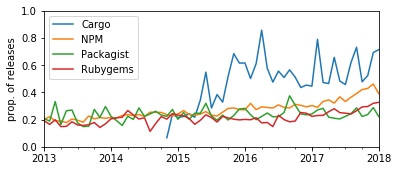

In [26]:
fig, ax = matplotlib.pyplot.subplots()

data = dict()

for ecosystem in ECOSYSTEMS:
    data[ecosystem] = (
        df_constraints[ecosystem]
        .assign(changes=1)
        .groupby(pandas.Grouper(key='constraint_next_date', freq='1M'))
        [['changes']]
        .sum()
        .merge(
            (
                df_versions[ecosystem]
                .assign(releases=1)
                .groupby(pandas.Grouper(key='date', freq='1M'))
                [['releases']]
                .sum()
            ),
            how='right',
            left_index=True,
            right_index=True,
        )
        .assign(**{ecosystem: lambda d: d['changes'] / d['releases']})
        [[ecosystem]]
    )
    
    data[ecosystem].plot(ax=ax, legend=False, color=COLORS[ecosystem])
    
ax.set(
    xlabel='',
    xlim=DATE_RANGE,
    ylabel='prop. of releases',
    ylim=(0, 1),
)

ax.legend(title=None)

savefig(fig, 'change_monthly_evolution')

In [27]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    .describe()
for ecosystem in ECOSYSTEMS], axis=1)

,Cargo,NPM,Packagist,Rubygems
count,38.000000,60.000000,60.000000,60.000000
mean,0.484797,0.269402,0.237405,0.209728
std,0.173415,0.062413,0.043738,0.041021
min,0.066667,0.178168,0.148733,0.113324
25%,0.397355,0.226728,0.209184,0.181473
50%,0.493202,0.254737,0.233462,0.206887
75%,0.602922,0.296588,0.266381,0.233701
max,0.858378,0.462061,0.375214,0.320042


## Duration of a constraint w.r.t. semver

Restrict to packages sufficiently updated. We consider the median value as a threshold:

In [28]:
df_frequently_updated = dict()

for ecosystem in ECOSYSTEMS:
    df_temp = (
        df_versions[ecosystem]
        .sort_values('rank')
        .drop_duplicates('package', keep='last')
        [lambda e: e['rank'] > e['rank'].median()]
    )
    print(ecosystem, df_temp['rank'].min())
    df_frequently_updated[ecosystem] = df_temp['package']

Cargo 4
NPM 4
Packagist 4
Rubygems 3


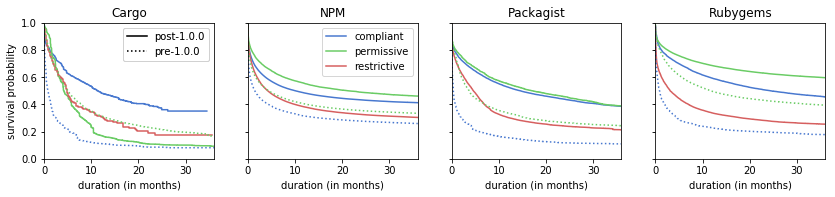

In [29]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_constraints[ecosystem]
        [lambda d: d['package'].isin(df_frequently_updated[ecosystem])]
        .assign(duration=lambda d: (d['constraint_next_date'].fillna(CENSOR_DATE) - d['date']) / pandas.to_timedelta(30, 'days'))
        .assign(observed=lambda d: ~d['constraint_next_date'].isnull())
    )
    
    kmf = lifelines.KaplanMeierFitter()
    for dev in (False, True):
        for j, constraint_type in enumerate(['compliant', 'permissive', 'restrictive']):
            mask = (lambda d: (d['dev'] == dev) & d[constraint_type])
            try:
                kmf.fit(data[ecosystem][mask]['duration'], data[ecosystem][mask]['observed'], label=constraint_type if not dev else '')
                kmf.plot(ax=ax, c=SEC_PALETTE[j], ci_show=False, legend=False, style=':' if dev else '-')
            except ValueError:
                pass
    ax.set(
        title=ecosystem,
        xlabel='duration (in months)',
        xlim=(0, 36),
        ylabel='survival probability',
        ylim=(0, 1),         
    )
    
legend = axes[0].legend(
    [matplotlib.lines.Line2D([0], [0], color='k'), matplotlib.lines.Line2D([0], [0], color='k', linestyle='dotted')],
    ['post-1.0.0', 'pre-1.0.0'],
)
axes[1].legend()
axes[0].add_artist(legend)

savefig(fig, 'change_constraint_duration')

In [30]:
for ecosystem in ECOSYSTEMS:
    print(ecosystem)
    
    for dev in (False, True):
        for A, B in itertools.combinations(['compliant', 'permissive', 'restrictive'], 2):
            mask_A = (lambda d: (d['dev'] == dev) & d[A])
            mask_B = (lambda d: (d['dev'] == dev) & d[B])
            
            try:
                test = logrank_test(
                    data[ecosystem][mask_A]['duration'], data[ecosystem][mask_B]['duration'],
                    data[ecosystem][mask_A]['observed'], data[ecosystem][mask_B]['observed'],
                    alpha=0.95,
                )
                print('({}) {} vs {}: {} ({:e})'.format('pre-1.0.0' if dev else 'post-1.0.0', A, B, (test.p_value < P_VALUE), test.p_value))
            except AssertionError:  # Don't know why lifelines does this?
                print('({}) {} vs {}: passed'.format('pre-1.0.0' if dev else 'post-1.0.0', A, B))
    
    print()
    for A in ['compliant', 'permissive', 'restrictive']:
        mask_A = (lambda d: ~d['dev'] & d[A])
        mask_B = (lambda d: d['dev'] & d[A])
        try:
            test = logrank_test(
                data[ecosystem][mask_A]['duration'], data[ecosystem][mask_B]['duration'],
                data[ecosystem][mask_A]['observed'], data[ecosystem][mask_B]['observed'],
                alpha=0.95,
            )
            print('({}) post-1.0.0 vs. pre-1.0.0: {} ({:e})'.format(A, test.p_value < P_VALUE, test.p_value))
        except (AssertionError, ValueError):  # Don't know why lifelines does this?
            print('({}) post-1.0.0 vs. pre-1.0.0: passed'.format(A))
    
    print()

Cargo
(post-1.0.0) compliant vs permissive: True (2.399494e-165)
(post-1.0.0) compliant vs restrictive: True (1.625471e-14)
(post-1.0.0) permissive vs restrictive: True (2.374461e-03)
(pre-1.0.0) compliant vs permissive: True (0.000000e+00)
(pre-1.0.0) compliant vs restrictive: False (nan)
(pre-1.0.0) permissive vs restrictive: False (nan)

(compliant) post-1.0.0 vs. pre-1.0.0: True (0.000000e+00)
(permissive) post-1.0.0 vs. pre-1.0.0: True (1.182227e-34)
(restrictive) post-1.0.0 vs. pre-1.0.0: False (nan)

NPM
(post-1.0.0) compliant vs permissive: True (4.739493e-232)
(post-1.0.0) compliant vs restrictive: True (0.000000e+00)
(post-1.0.0) permissive vs restrictive: True (0.000000e+00)
(pre-1.0.0) compliant vs permissive: True (0.000000e+00)
(pre-1.0.0) compliant vs restrictive: False (nan)
(pre-1.0.0) permissive vs restrictive: False (nan)

(compliant) post-1.0.0 vs. pre-1.0.0: True (0.000000e+00)
(permissive) post-1.0.0 vs. pre-1.0.0: True (0.000000e+00)
(restrictive) post-1.0.0 vs. 

## Proportion of changes w.r.t. original and new constraint semantics

Restricted to 2017 (to limit the impact of some ecosystem-specific changes).

In [55]:
data = dict()

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_constraints[ecosystem]
        [lambda d: ~d['dev']]
        [lambda d: d['constraint_next_date'].between(pandas.to_datetime('2017-01-01'), pandas.to_datetime('2018-01-01'))]
        .assign(
           kind=lambda d: d[['compliant', 'permissive', 'restrictive']].apply(lambda s: s.values.argmax(), axis=1)
        )
        .pipe(lambda d: 
            d[['package', 'target', 'kind', 'constraint_next_rank']]
            .merge(
                d[['package', 'target', 'kind', 'rank']],
                how='inner',
                left_on=['package', 'target', 'constraint_next_rank'],
                right_on=['package', 'target', 'rank'],
                suffixes=('', '_new'),
            )        
        )
        .assign(n=1)
        .groupby(['kind', 'kind_new'], as_index=False)
        [['n']]
        .count()
        .replace({
            'kind': {0: 'compliant', 1: 'permissive', 2: 'restrictive'},
            'kind_new': {0: 'compliant', 1: 'permissive', 2: 'restrictive'},
        })
        .pivot('kind', 'kind_new', 'n')
    )

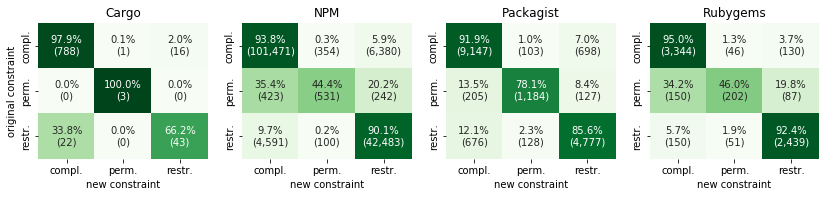

In [56]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=False)
fig.set_size_inches(FIG_SIZE_WIDE)

short_names = {
    'compliant': 'compl.',
    'permissive': 'perm.', 
    'restrictive': 'restr.',
}

for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    labels = (
        data[ecosystem]
        .apply(lambda s: s / s.sum(), axis=1)
        .reset_index()
        .set_index('kind')
        .fillna(0)
        [['compliant', 'permissive', 'restrictive']]
        .loc[['compliant', 'permissive', 'restrictive']]
        .rename(columns=short_names, index=short_names)
        .applymap(lambda s: '{:.1%}\n'.format(s))
    ) + (
        data[ecosystem]
        .reset_index()
        .set_index('kind')
        .fillna(0)
        [['compliant', 'permissive', 'restrictive']]
        .loc[['compliant', 'permissive', 'restrictive']]
        .rename(columns=short_names, index=short_names)
        .applymap(lambda s: '({:,d})'.format(int(s)))
    ) 
    
    seaborn.heatmap(
        (
            data[ecosystem]
            .apply(lambda s: s / s.sum(), axis=1)
            .reset_index()
            .set_index('kind')
            .fillna(0)
            [['compliant', 'permissive', 'restrictive']]
            .loc[['compliant', 'permissive', 'restrictive']]
            .rename(columns=short_names, index=short_names)
        ),
        cmap='Greens',
        cbar=False,
        annot=labels,
        fmt='s',
        center=0.5,
        ax=ax
    )
    
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
        # tick.set_horizontalalignment('right')
    for tick in ax.get_yticklabels():
        tick.set_rotation(90)
        tick.set_verticalalignment('center')
    
    ax.set(
        title=ecosystem,
        xlabel='new constraint',
        ylabel='original constraint' if i == 0 else '',
    )
    
savefig(fig, 'change_proportion_original_new')

# Constraint specialization

A package is said to be *specialized* if a large proportion of its reverse dependencies agree on their constraints (i.e. they are either compliant, permissive or restrictive).

## Proportion of required packages that are specialized

For this analysis, we restricted the set of packages that were active after 2017-01-01, and we consider the dependencies of the highest available version of each package during this period. Finally, we restricted the set of *required packages* to the one that are at least required by 2 other packages with non pre-1.0.0 constraints.

In [34]:
threshold = 0.95
min_required = 2

mask = lambda d: (
    d
    [lambda d: d['date'] >= pandas.to_datetime('2017-01-01')]
    [lambda d: ~d['dev']]
    .sort_values('rank')
    .drop_duplicates(['package', 'target'], keep='last')
)

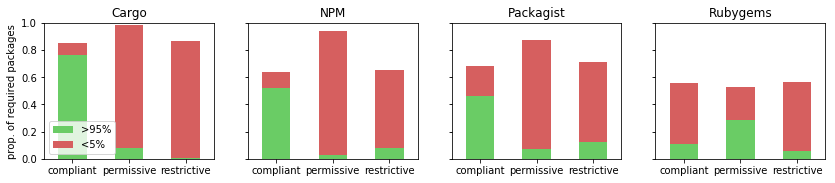

In [35]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        .pipe(mask)
        .assign(dependents=1)
        .groupby(['target'], sort=False)
        [['dependents', 'compliant', 'permissive', 'restrictive']]
        .sum()
        [lambda d: d['dependents'] >= min_required]
        .pipe(lambda d: d.apply(lambda s: s / d['dependents']))
        .pipe(
            pandas.melt,
            value_vars=['compliant', 'permissive', 'restrictive'],
            var_name='constraint', 
            value_name='proportion',
        )
        .assign(
            above=lambda d: d['proportion'] >= threshold,
            below=lambda d: d['proportion'] <= (1 - threshold),
            inside=lambda d: (d['proportion'] < threshold) & (d['proportion'] > (1 - threshold))
        )
        .groupby('constraint', sort=False)
        [['above', 'inside', 'below']]
        .sum()
        .apply(lambda s: s / s.sum(), axis=1)
        .reset_index()
    )
    
    (
        data[ecosystem]
        [['constraint', 'above', 'below']]
        .rename(columns={
            'above': '>{:.0%}'.format(threshold), 
            #'inside': '{:.0%}-{:.0%}'.format(*threshold), 
            'below': '<{:.0%}'.format(1 - threshold)
        })
        .plot.bar(x='constraint', stacked=True, color=[SEC_PALETTE[1], SEC_PALETTE[2]], ax=ax)
    )
    
    ax.set(
        title=ecosystem,
        xlabel='',
        ylabel='prop. of required packages',
        ylim=(0, 1),
    )
    ax.legend().remove()
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)

axes[0].legend(loc='lower left')
savefig(fig, 'required_specialization_accept_reject_stacked')

In [36]:
(
    pandas.concat([df.assign(ecosystem=ecosystem) for ecosystem, df in data.items()])
    [['ecosystem', 'constraint', 'above', 'below', 'inside']]
)

,ecosystem,constraint,above,below,inside
0,NPM,compliant,0.517503,0.123149,0.359347
1,NPM,permissive,0.029874,0.912187,0.057939
2,NPM,restrictive,0.082385,0.569487,0.348128
0,Rubygems,compliant,0.108941,0.446281,0.444778
1,Rubygems,permissive,0.284373,0.240421,0.475207
2,Rubygems,restrictive,0.057476,0.508264,0.434260
0,Cargo,compliant,0.761702,0.093617,0.144681
1,Cargo,permissive,0.080851,0.906383,0.012766
2,Cargo,restrictive,0.008511,0.859574,0.131915
0,Packagist,compliant,0.463872,0.219112,0.317016


## Monthly evolution of the number of specialized packages (pre-1.0.0)

... based on the constraints that are declared during the month.
All constraints are considered, but only required packages with at least some dependents are considered.

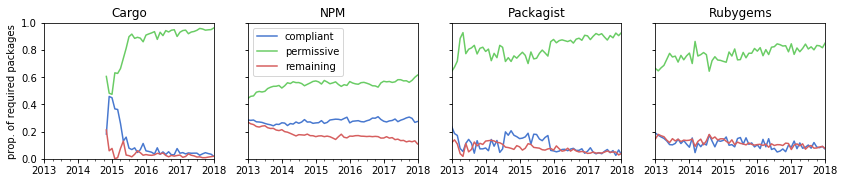

In [65]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: d['dev']]
        .assign(dependents=1)
        .groupby(['target', pandas.Grouper(key='date', freq='M')], sort=False)
        [['dependents', 'compliant', 'permissive', 'restrictive']]
        .sum()
        [lambda d: d['dependents'] >= min_required]
        .reset_index(level='target', drop=True)
        .assign(
            compliant=lambda d: d['compliant'] >= threshold * d['dependents'],
            permissive=lambda d: d['permissive'] >= threshold * d['dependents'],
            restrictive=lambda d: d['restrictive'] >= threshold * d['dependents'],
        )
        .drop(columns=['dependents'])
        .assign(required=1)
        .groupby(level='date')
        .sum()
        .apply(lambda d: d / d['required'], axis=1)
        .assign(remaining=lambda d: 1 - d['compliant'] - d['permissive'] - d['restrictive'])
    )
    
    (
        data[ecosystem]
        [['compliant', 'permissive', 'remaining']]
        .rename(columns={
        #    'compliant': 'mostly compliant',
        #    'permissive': 'mostly permissive', 
        #    'restrictive': 'mostly restrictive',
        })
        .plot(ax=ax, legend=False, color=SEC_PALETTE, style=['-', '-', '-', ':'])
    )
        
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='prop. of required packages',
        ylim=(0, 1),
    )
    
# axes[-1].legend(loc='upper left', ncol=4, bbox_to_anchor=(-2, 1))
axes[1].legend(loc='upper left')

savefig(fig, 'required_specialized_by_month_pre')

In [75]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .describe()
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'compliant', 'permissive', 'restrictive', 'remaining']]
    .loc[['mean', '50%']]
    for ecosystem in ECOSYSTEMS], axis=0
)

,ecosystem,compliant,permissive,restrictive,remaining
mean,Cargo,0.101910,0.862737,0.0,0.035354
50%,Cargo,0.049480,0.919667,0.0,0.025887
mean,NPM,0.276260,0.546456,0.0,0.177284
50%,NPM,0.274805,0.554948,0.0,0.167067
mean,Packagist,0.102038,0.820261,0.0,0.077701
50%,Packagist,0.074912,0.820826,0.0,0.073281
mean,Rubygems,0.110311,0.770983,0.0,0.118707
50%,Rubygems,0.105448,0.776358,0.0,0.112946


In [69]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'compliant', 'permissive', 'restrictive', 'remaining']]
    .iloc[-1]
for ecosystem in ECOSYSTEMS], axis=1)

,37,84,69,140
ecosystem,Cargo,NPM,Packagist,Rubygems
compliant,0.0337662,0.267912,0.0653595,0.0913706
permissive,0.950649,0.599816,0.906318,0.817259
restrictive,0,0,0,0
remaining,0.0155844,0.132272,0.0283224,0.0913706


## Monthly evolution of the number of specialized packages (post-1.0.0)

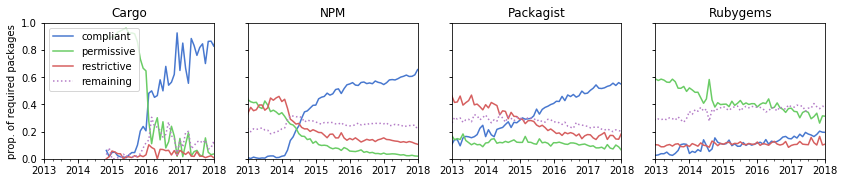

In [76]:
fig, axes = matplotlib.pyplot.subplots(nrows=1, ncols=4, sharex=True, sharey=True)
fig.set_size_inches(FIG_SIZE_WIDE)

data = dict()
for i, ecosystem in enumerate(ECOSYSTEMS):
    ax = axes[i]
    
    data[ecosystem] = (
        df_dependencies[ecosystem]
        [lambda d: ~d['dev']]
        .assign(dependents=1)
        .groupby(['target', pandas.Grouper(key='date', freq='M')], sort=False)
        [['dependents', 'compliant', 'permissive', 'restrictive']]
        .sum()
        [lambda d: d['dependents'] >= min_required]
        .reset_index(level='target', drop=True)
        .assign(
            compliant=lambda d: d['compliant'] >= threshold * d['dependents'],
            permissive=lambda d: d['permissive'] >= threshold * d['dependents'],
            restrictive=lambda d: d['restrictive'] >= threshold * d['dependents'],
        )
        .drop(columns=['dependents'])
        .assign(required=1)
        .groupby(level='date')
        .sum()
        .apply(lambda d: d / d['required'], axis=1)
        .assign(remaining=lambda d: 1 - d['compliant'] - d['permissive'] - d['restrictive'])
    )
    
    (
        data[ecosystem]
        [['compliant', 'permissive', 'restrictive', 'remaining']]
        .rename(columns={
        #    'compliant': 'mostly compliant',
        #    'permissive': 'mostly permissive', 
        #    'restrictive': 'mostly restrictive',
        })
        .plot(ax=ax, legend=False, color=SEC_PALETTE, style=['-', '-', '-', ':'])
    )
        
    ax.set(
        title=ecosystem,
        xlabel='',
        xlim=DATE_RANGE,
        ylabel='prop. of required packages',
        ylim=(0, 1),
    )
    
# axes[-1].legend(loc='upper left', ncol=4, bbox_to_anchor=(-2, 1))
axes[0].legend(loc='upper left')

savefig(fig, 'required_specialized_by_month_post')

In [77]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .describe()
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'compliant', 'permissive', 'restrictive', 'remaining']]
    .loc[['mean', '50%']]
    for ecosystem in ECOSYSTEMS], axis=0
)

,ecosystem,compliant,permissive,restrictive,remaining
mean,Cargo,0.439907,0.418496,0.035338,0.106258
50%,Cargo,0.500000,0.238766,0.026354,0.091214
mean,NPM,0.370929,0.153778,0.224105,0.251188
50%,NPM,0.479297,0.082335,0.177358,0.251961
mean,Packagist,0.339742,0.115659,0.274848,0.269751
50%,Packagist,0.322355,0.116328,0.253801,0.272549
mean,Rubygems,0.110834,0.427238,0.108119,0.353809
50%,Rubygems,0.110742,0.406061,0.106098,0.368388


In [78]:
pandas.concat([
    data[ecosystem]
    .reset_index()
    [lambda d: d['date'].between(*DATE_RANGE)]
    .assign(ecosystem=ecosystem)
    [['ecosystem', 'compliant', 'permissive', 'restrictive', 'remaining']]
    .iloc[-1]
for ecosystem in ECOSYSTEMS], axis=1)

,37,84,75,157
ecosystem,Cargo,NPM,Packagist,Rubygems
compliant,0.865672,0.618016,0.560683,0.195822
permissive,0.0298507,0.0208503,0.087936,0.315927
restrictive,0.0223881,0.113082,0.143895,0.101828
remaining,0.0820896,0.248052,0.207485,0.386423


# Special cases and examples

## Identifying breaking changes?

In [38]:
packages = [
    ('NPM', 'underscore', '1.7.0'),
    ('NPM', 'underscore', '1.8.0'),
    ('Rubygems', 'i18n', '0.5.0'),
    ('NPM', 'typescript', '2.1.1'),
]

timeframe = (pandas.to_timedelta('365D'), pandas.to_timedelta('365D'))

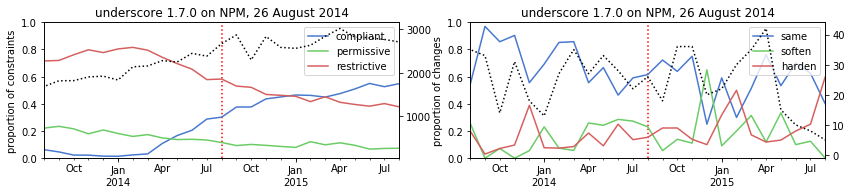

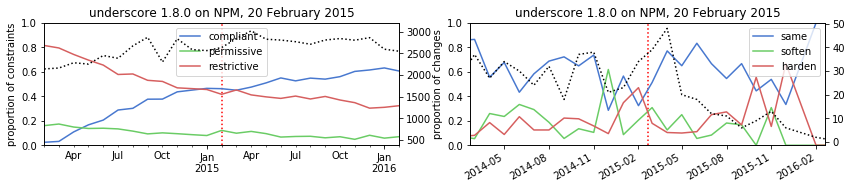

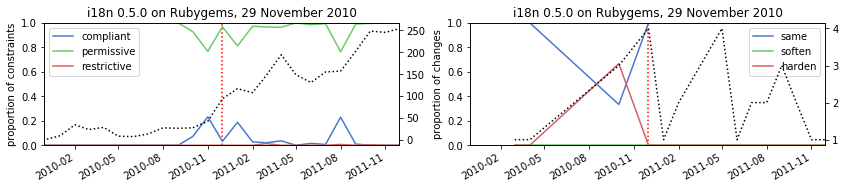

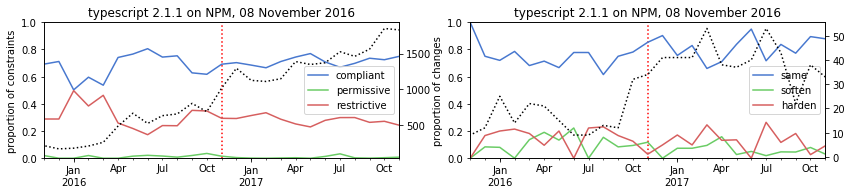

In [39]:
for ecosystem, package, version in packages:
    fig, (ax, ax2) = matplotlib.pyplot.subplots(ncols=2)
    fig.set_size_inches(FIG_SIZE_WIDE[0], FIG_SIZE[1])
    
    date = df_versions[ecosystem][lambda d: (d['package'] == package) & (d['version'] == version)]['date'].iloc[0]
    
    _ = (
        df_dependencies[ecosystem]
        [lambda d: d['target'] == package]
        [lambda d: d['date'].between(date - pandas.to_timedelta('90D') - timeframe[0], date + timeframe[1] + pandas.to_timedelta('90D'))]
        .assign(constraints=1)
        .groupby(pandas.Grouper(key='date', freq='M'))
        [['constraints', 'compliant', 'permissive', 'restrictive']]
        .sum()
        [lambda d: d['constraints'] > 0]
        .assign(
            compliant=lambda d: d['compliant'] / d['constraints'],
            permissive=lambda d: d['permissive'] / d['constraints'],
            restrictive=lambda d: d['restrictive'] / d['constraints'],
        )
        [['compliant', 'permissive', 'restrictive', 'constraints']]
    )
    _.index = _.index + pandas.to_timedelta('1D')
    
    _.drop(columns=['constraints']).plot(ax=ax, color=SEC_PALETTE)
    _[['constraints']].plot(ax=ax, secondary_y=True, legend=False, color='k', style=':')
    
    ax.vlines(date, 0, 1, colors='r', linestyles='dotted')
    ax.set(
        title='{} {} on {}, {}'.format(package, version, ecosystem, date.strftime('%d %B %Y')),
        xlabel='',
        xlim=(date - timeframe[0], date + timeframe[1]),
        ylabel='proportion of constraints',
        ylim=(0, 1),
    )
    
    
    ########################################
    
    ax = ax2
    
    _ = (
        df_constraints[ecosystem]
        [lambda d: d['target'] == package]
        [lambda d: d['constraint_next_date'].between(date - pandas.to_timedelta('90D') - timeframe[0], date + timeframe[1] + pandas.to_timedelta('90D'))]
        .assign(kind=lambda d: d[['restrictive', 'compliant', 'permissive']].apply(lambda s: s.values.argmax(), axis=1))
        [['package', 'target', 'constraint_next_date', 'rank', 'kind', 'constraint_next_rank']]
        .pipe(lambda df: 
            df.merge(
                df, how='inner', left_on=['package', 'target', 'constraint_next_rank'], right_on=['package', 'target', 'rank'],
                suffixes=('', '_new'),
            )
        )
        .assign(
            changes=1, 
            same=lambda d: d['kind_new'] == d['kind'],
            soften=lambda d: d['kind_new'] > d['kind'],
            harden=lambda d: d['kind_new'] < d['kind'],
        )
        .groupby(pandas.Grouper(key='constraint_next_date', freq='M'))
        [['changes', 'same', 'soften', 'harden']]
        .sum()
        [lambda d: d['changes'] > 0]
    )

    _.index = _.index + pandas.to_timedelta('1D')
    
    _.apply(lambda s: s / s['changes'], axis=1).drop(columns=['changes']).plot(ax=ax, legend=True, color=SEC_PALETTE)
    _[['changes']].plot(ax=ax, secondary_y=True, legend=False, color='k', style=':')
    
    ax.vlines(date, 0, 1, colors='r', linestyles='dotted')
    ax.set(
        title='{} {} on {}, {}'.format(package, version, ecosystem, date.strftime('%d %B %Y')),
        xlabel='',
        xlim=(date - timeframe[0], date + timeframe[1]),
        ylabel='proportion of changes',
        ylim=(0, 1),
    )
    

## Migration from underscore to lodash?

[(0, 1500), (528, 552)]

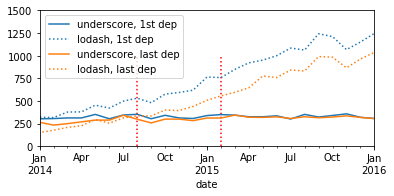

In [40]:
fig, ax = matplotlib.pyplot.subplots()

(
    df_dependencies['NPM']
    [lambda d: d['target'] == 'underscore']
    [['package', 'rank', 'date']]
    .sort_values('rank')
    .drop_duplicates('package', keep='first')
    .groupby(pandas.Grouper(key='date', freq='M'))
    .count()
    [['package']]
    .rename(columns={'package': 'underscore, 1st dep'})
    .plot(ax=ax, color=PALETTE[0])
)

(
    df_dependencies['NPM']
    [lambda d: d['target'] == 'lodash']
    [['package', 'rank', 'date']]
    .sort_values('rank')
    .drop_duplicates('package', keep='first')
    .groupby(pandas.Grouper(key='date', freq='M'))
    .count()
    [['package']]
    .rename(columns={'package': 'lodash, 1st dep'})
    .plot(ax=ax, color=PALETTE[0], style=':')
)

(
    df_dependencies['NPM']
    [lambda d: d['target'] == 'underscore']
    [['package', 'rank', 'date']]
    .sort_values('rank')
    .drop_duplicates('package', keep='last')
    .groupby(pandas.Grouper(key='date', freq='M'))
    .count()
    [['package']]
    .rename(columns={'package': 'underscore, last dep'})
    .plot(ax=ax, color=PALETTE[1])
)

(
    df_dependencies['NPM']
    [lambda d: d['target'] == 'lodash']
    [['package', 'rank', 'date']]
    .sort_values('rank')
    .drop_duplicates('package', keep='last')
    .groupby(pandas.Grouper(key='date', freq='M'))
    .count()
    [['package']]
    .rename(columns={'package': 'lodash, last dep'})
    .plot(ax=ax, color=PALETTE[1], style=':')
)

ax.vlines(pandas.to_datetime('2014-08-26'), 0, 1000, colors='r', linestyles='dotted')
ax.vlines(pandas.to_datetime('2015-02-20'), 0, 1000, colors='r', linestyles='dotted')

ax.set(
    xlim=(pandas.to_datetime('2014-01-01'), pandas.to_datetime('2016-01-01')),
    ylim=(0, 1500)
)